# Feature Engineering Notebook

## Objectives

- Engineer features for Classification, Regression and Cluster modelsTransform categorical variables
- Scale/normalize numerical features
- Create meaningful new features (e.g., total area, age)
- Ensure train and test sets are treated identically

## Inputs

* inputs/datasets/cleaned/train_set.csv
* inputs/datasets/cleaned/test_set.csv

## Outputs

* generate a list with variables to engineer

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/housing-prices/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/housing-prices'

---

# Load Cleaned Data

Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/train_set.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1314,0.0,3.0,No,922,Rec,392,294,RFn,1957.0,...,8400,70.0,0.0,0,6,5,1314,1957,1957,145000
1,799,772.0,3.0,No,0,Unf,799,380,RFn,1993.0,...,7837,59.0,0.0,40,7,6,799,1993,1994,178000
2,796,0.0,2.0,No,0,Unf,796,0,NaN,0.0,...,8777,67.0,0.0,0,7,5,796,1910,1950,85000
3,981,787.0,3.0,No,569,ALQ,162,240,Unf,1939.0,...,7200,60.0,252.0,0,7,5,731,1937,1950,175000
4,1026,665.0,3.0,No,218,LwQ,808,308,Unf,1924.0,...,5000,50.0,0.0,0,6,5,1026,1924,1950,127000


Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/test_set.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1068,0.0,3.0,No,663,GLQ,396,264,RFn,1963.0,...,8414,70.0,0.0,0,8,6,1059,1963,2003,154500
1,1500,0.0,3.0,Av,1032,GLQ,431,712,RFn,1994.0,...,12256,98.0,362.0,32,5,8,1463,1994,1995,325000
2,1028,0.0,2.0,No,0,Unf,1008,360,Unf,1927.0,...,8960,56.0,0.0,0,6,5,1008,1927,1950,115000
3,1004,0.0,3.0,No,399,ALQ,605,420,NaN,1950.0,...,5000,50.0,0.0,24,7,6,1004,1947,1950,159000
4,1620,0.0,2.0,Gd,1022,GLQ,598,912,Fin,2008.0,...,12898,89.0,70.0,0,5,9,1620,2007,2008,315500


# Data Exploration

In feature engineering, you are interested to evaluate which potential transformation you could do in your variables
* Take your notes in your separate spreadsheet

In [ ]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

# Correlation and PPS Analysis

* We've already done the correlation analysis and no new features were added:

- We ran Pearson correlation
- Plotted and interpreted scatter plots for top predictors
- Used it to satisfy Business Requirement 1

* We want to keep feature engineering simple, so we'll PPS for now

# Feature Engineering

## Custom function

We studied this custom function in the feature-engine lesson. That will help you with the feature engineering process.
* Do not worry if you need help understanding the full code at first, as it is expected you will take some time to absorb the use case.
* At this moment, what matters is to understand the function objective and how you can use it.

In [6]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


## Feature Engineering Spreadsheet Summary

* Consider the notes taken in your spreadsheet summary. List the transformers you will use
    * Categorical Encoding
    * Numerical Transformation
    * Smart Correlation Selection

## Dealing with Feature Engineering

### Categorical Encoding - Ordinal: replaces categories with ordinal numbers 

* Step 1: Select variable(s)

In [11]:
selected_cat_cols = ['KitchenQual', 'BsmtExposure', 'GarageFinish']

* Step 2: Create a separate DataFrame, with your variable(s)

In [12]:
X_train = TrainSet.drop(columns=['SalePrice'])
y_train = TrainSet['SalePrice']

* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



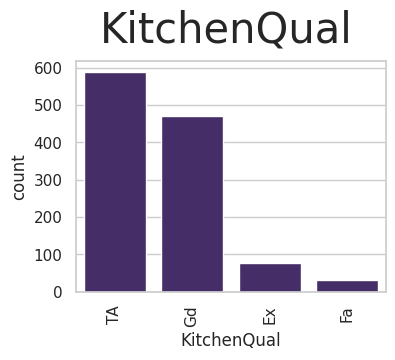

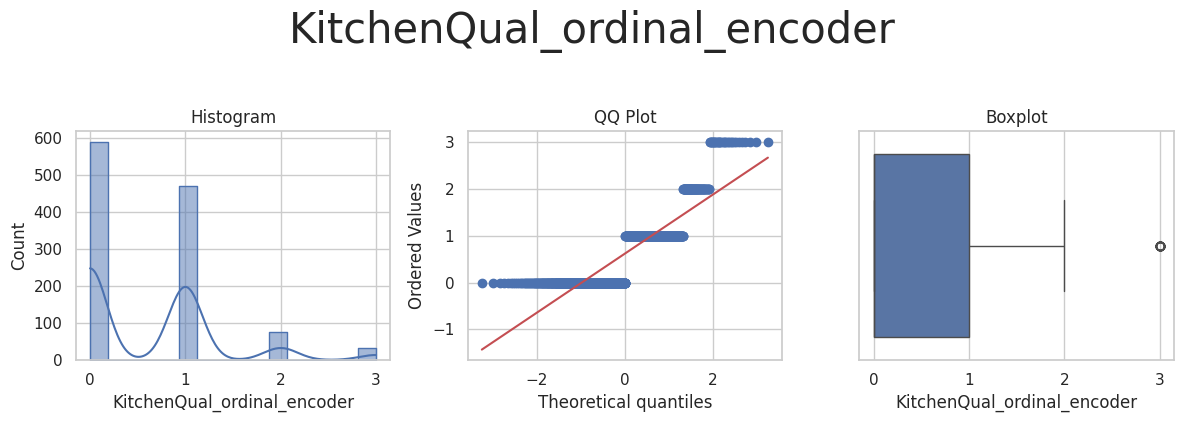



* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



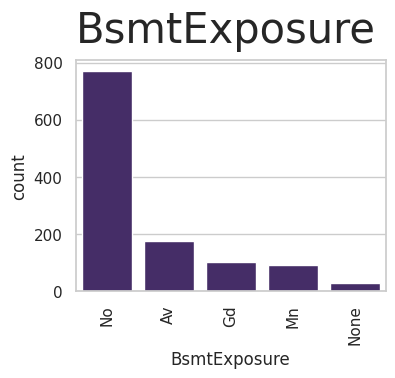

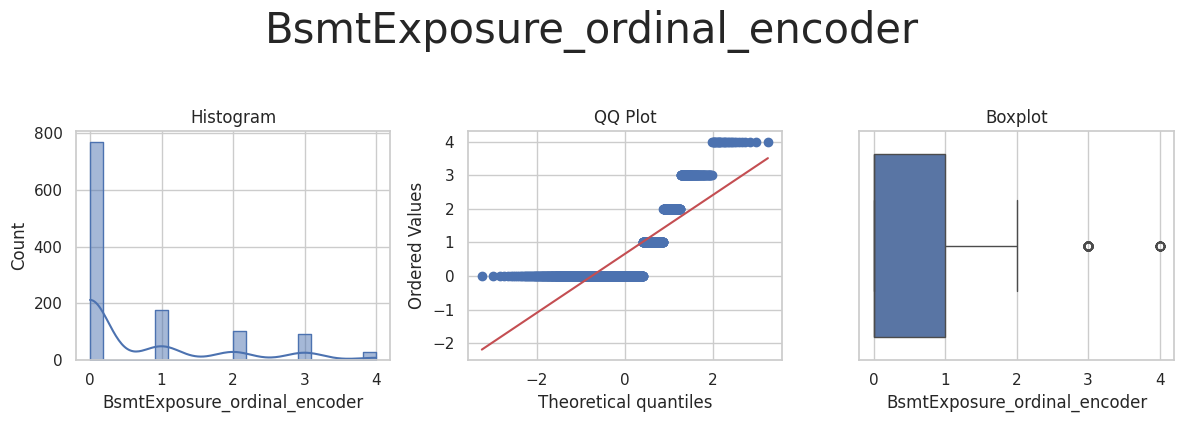



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



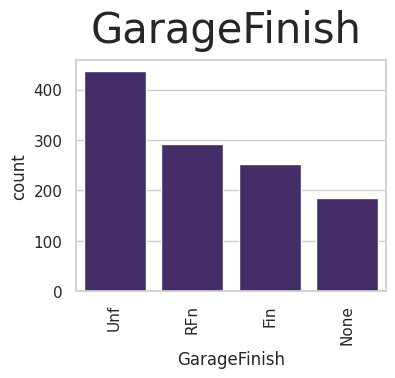

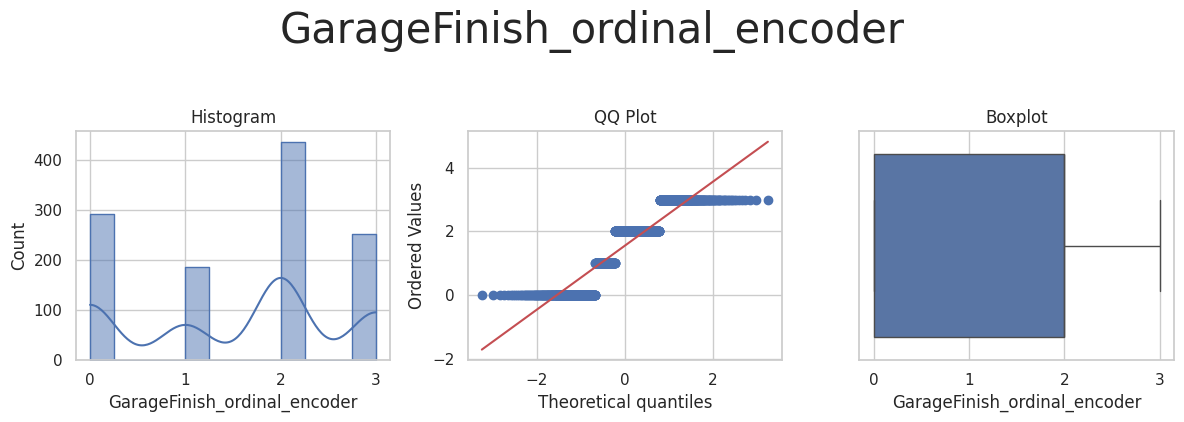

,KitchenQual,KitchenQual_ordinal_encoder,BsmtExposure,BsmtExposure_ordinal_encoder,GarageFinish,GarageFinish_ordinal_encoder
0,TA,0,No,0,RFn,0
1,TA,0,No,0,RFn,0
2,TA,0,No,0,None,1
3,Gd,1,No,0,Unf,2
4,Gd,1,No,0,Unf,2
...,...,...,...,...,...,...
1163,Gd,1,No,0,RFn,0
1164,Gd,1,No,0,Unf,2
1165,TA,0,No,0,Unf,2
1166,Gd,1,No,0,Unf,2


In [15]:
#Custom Function FeatureEngineeringAnalysis() caught some missing valuesin the input DataFrame.
#Run this first to see which column(s) have missing values:
#X_train[selected_cat_cols].isnull().sum()
#`KitchenQual` is fully complete ; `BsmtExposure`` has 28 missing values; `GarageFinish`` has 186 missing values
#Fixing the missing values
X_train['BsmtExposure'] = X_train['BsmtExposure'].fillna('None')
X_train['GarageFinish'] = X_train['GarageFinish'].fillna('None')
FeatureEngineeringAnalysis(X_train[selected_cat_cols], analysis_type='ordinal_encoder')

* For each variable, write your conclusion on how the transformation(s) look(s) to be effective.
  * For all variables, the transformation is effective, since it converted categories to numbers.



* Step 4 - Apply the selected transformation to the Train and Test set

In [16]:
from feature_engine.encoding import OrdinalEncoder

encoder = OrdinalEncoder(encoding_method='arbitrary', variables=selected_cat_cols)
X_train = encoder.fit_transform(X_train)

### Numerical Transformation

* Step 1: Select variable(s)

In [7]:
selected_num_cols = ['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'LotArea']

* Step 2: Create a separate DataFrame, with your variable(s)

In [8]:
# Separate features and target
X_train = TrainSet.drop(columns=['SalePrice'])
y_train = TrainSet['SalePrice']

* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method

* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



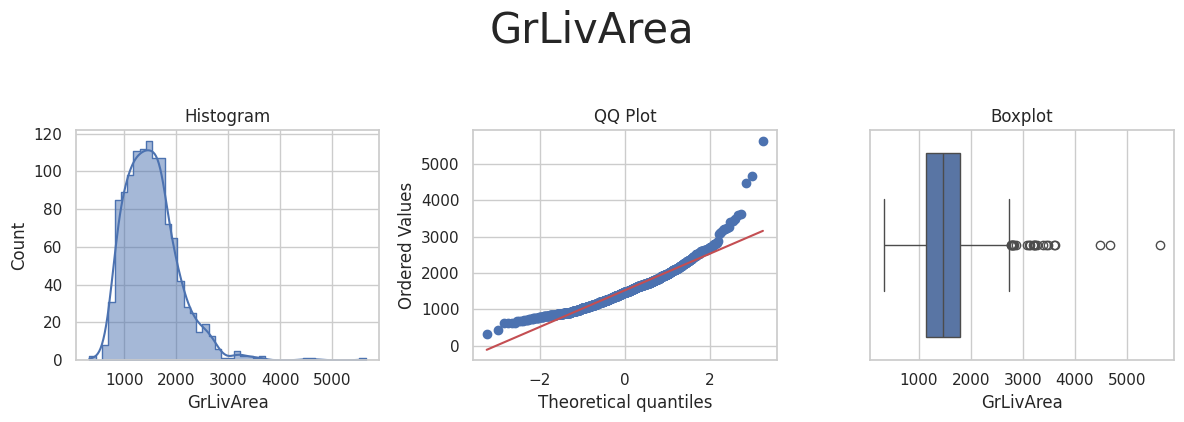

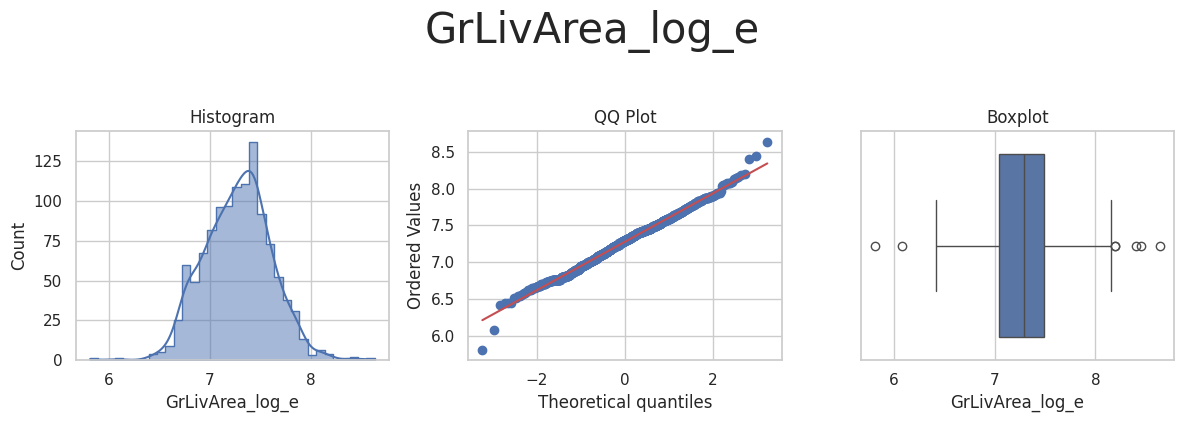

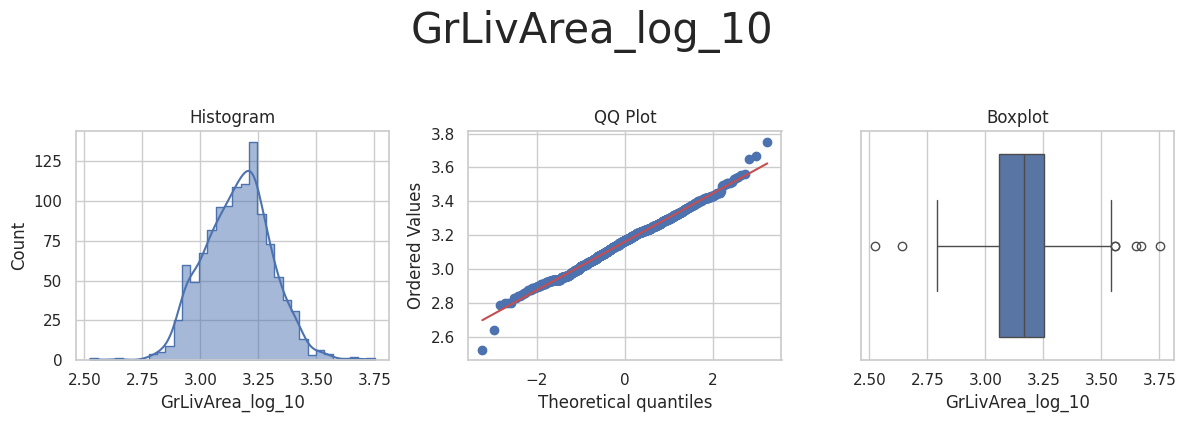

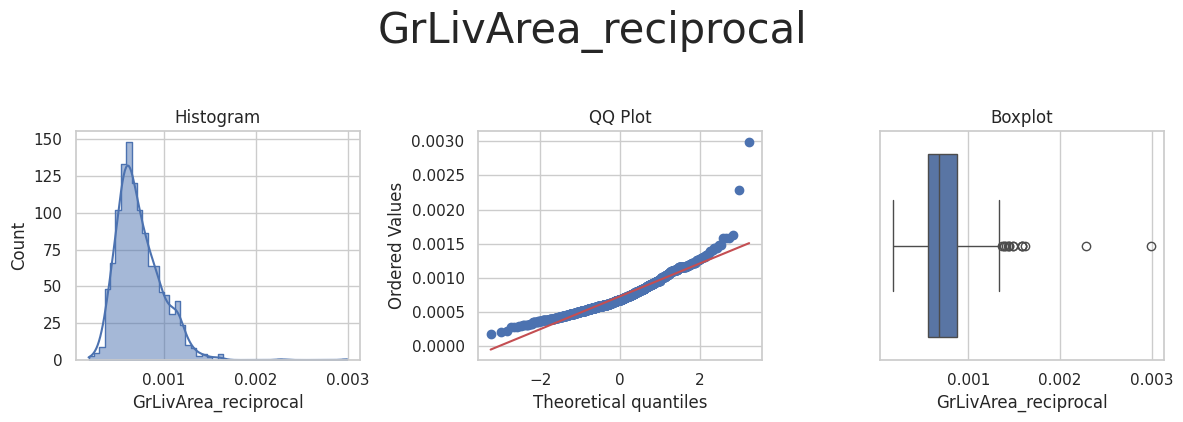

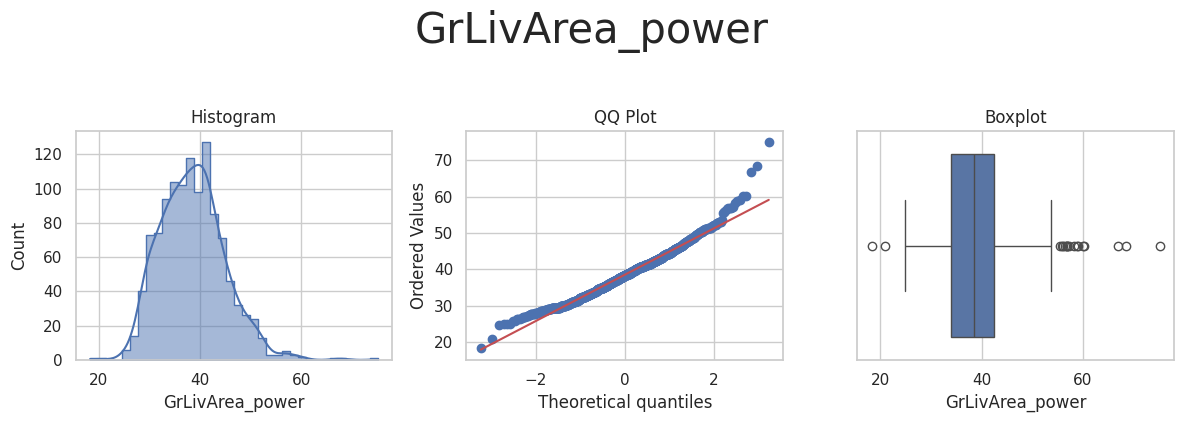

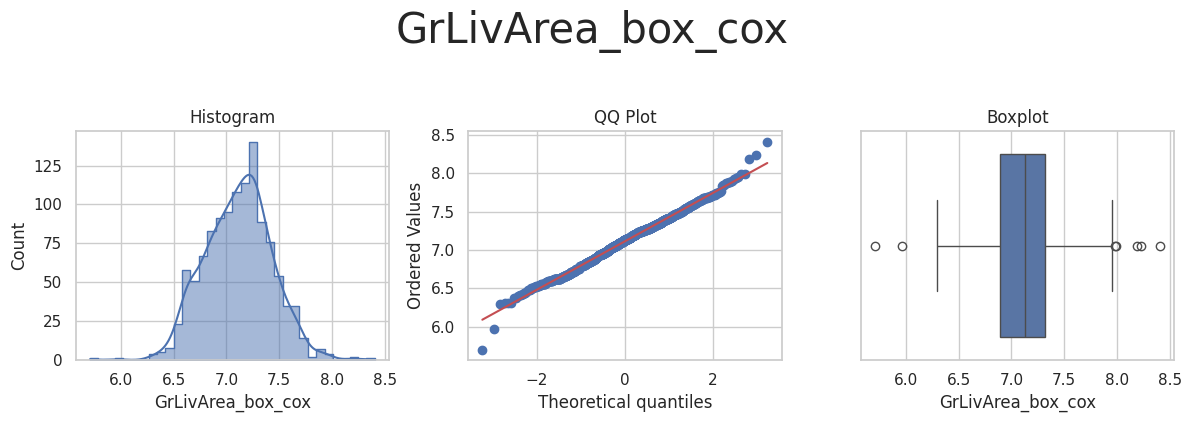

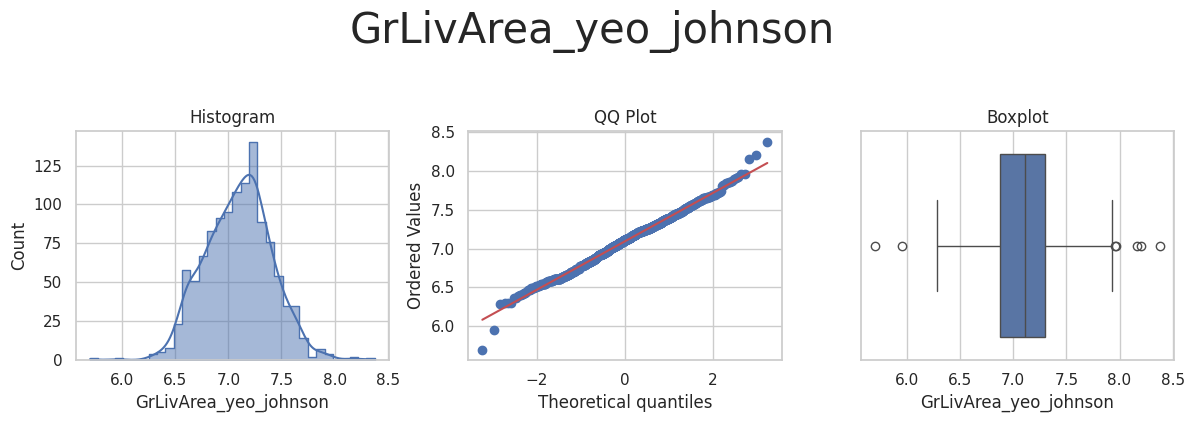



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



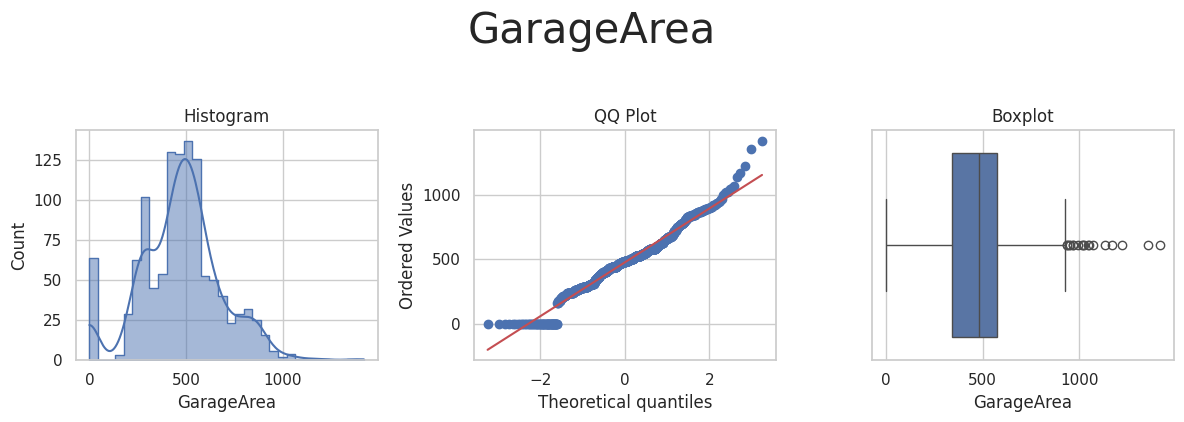

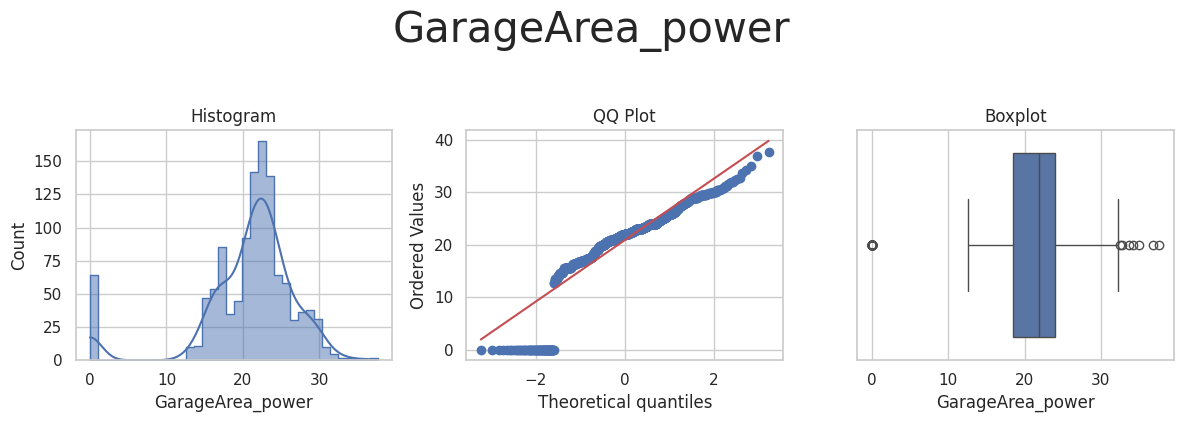

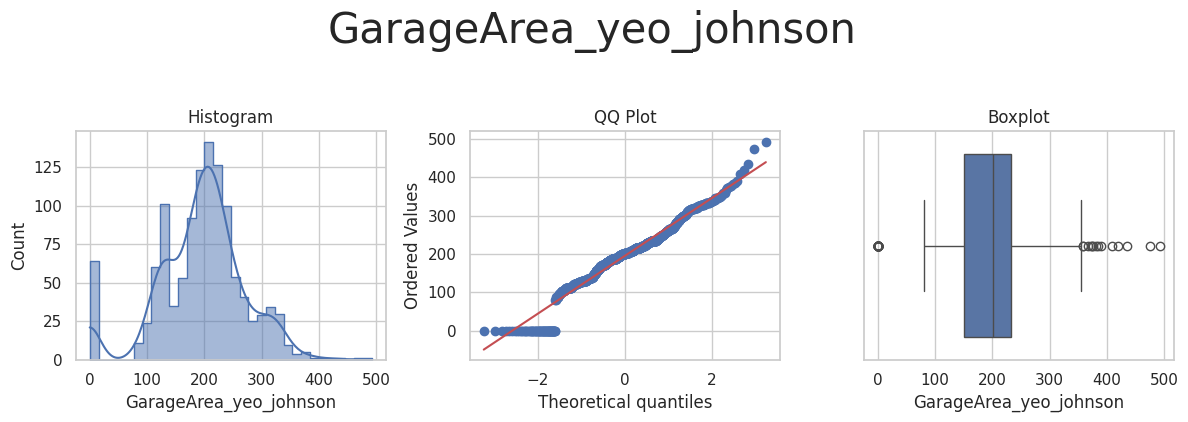



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



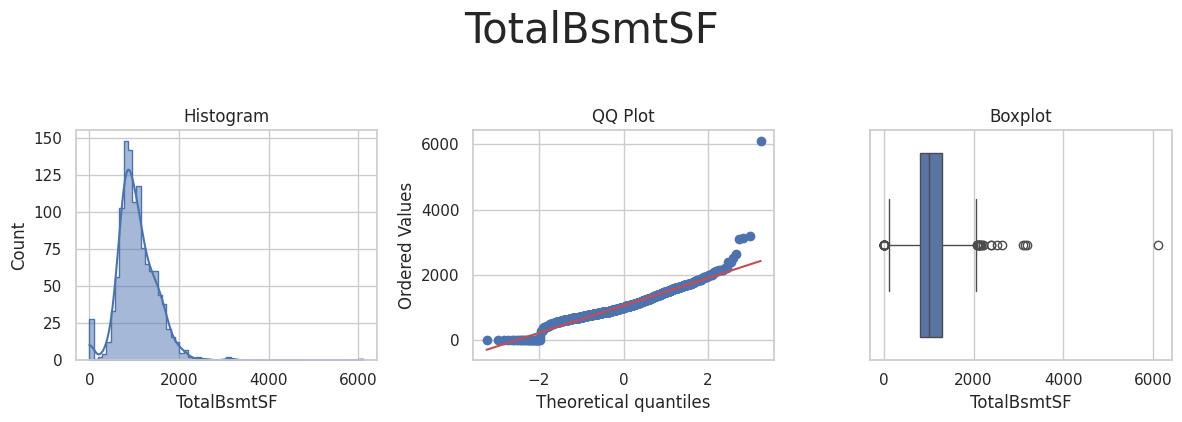

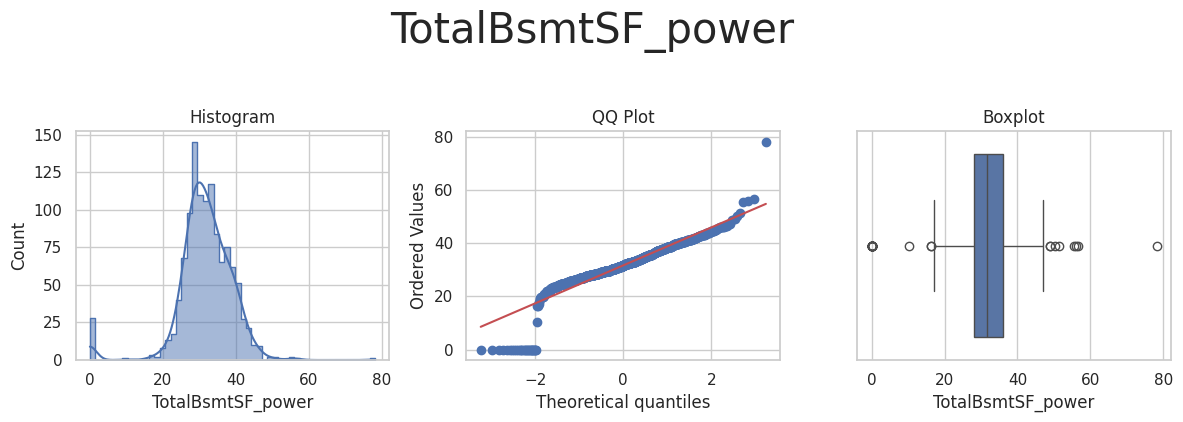

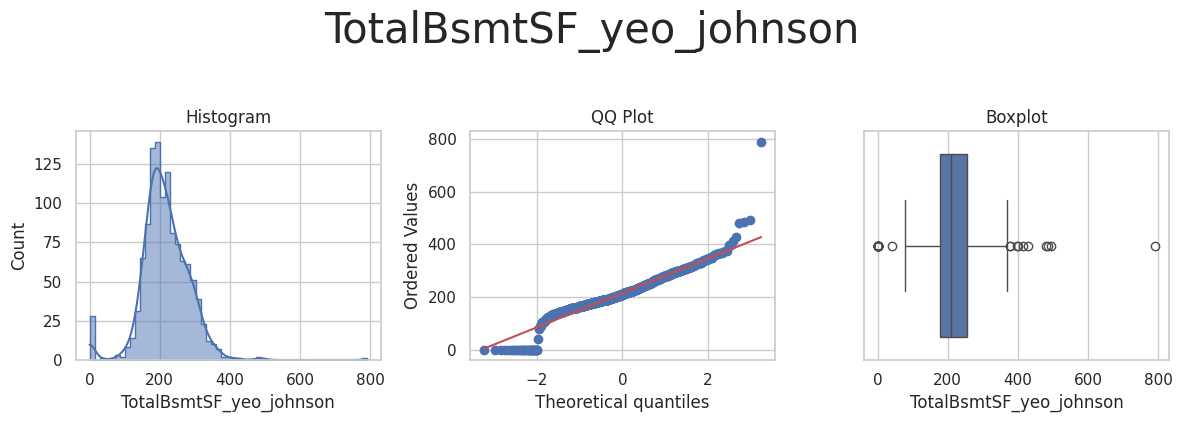



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



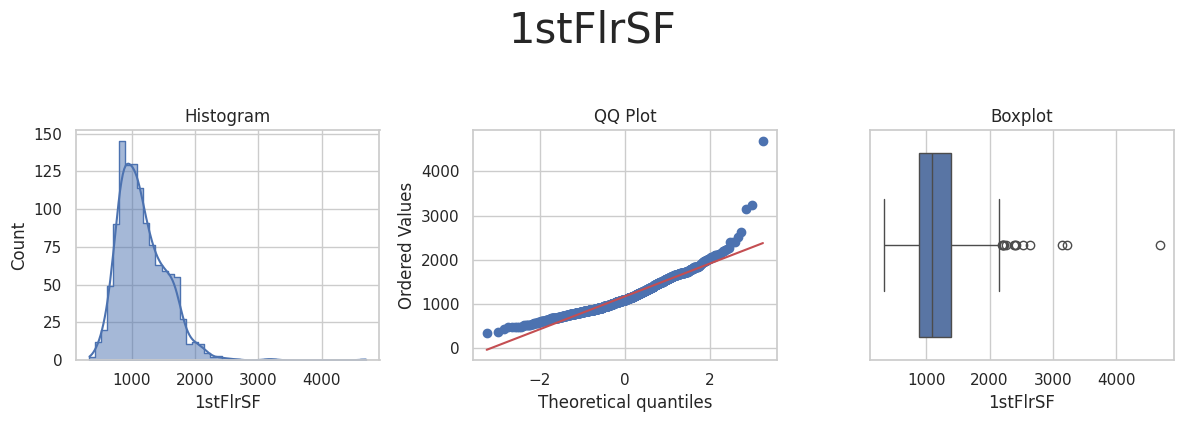

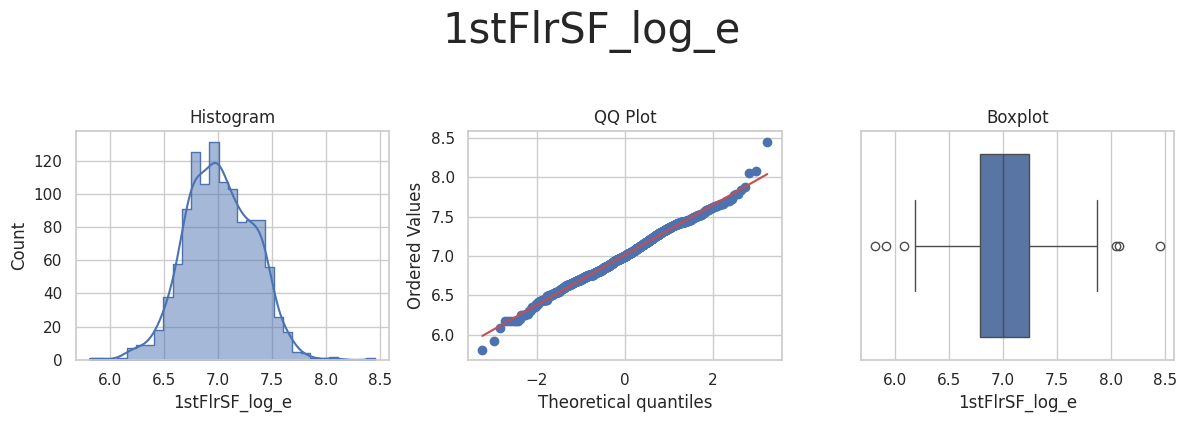

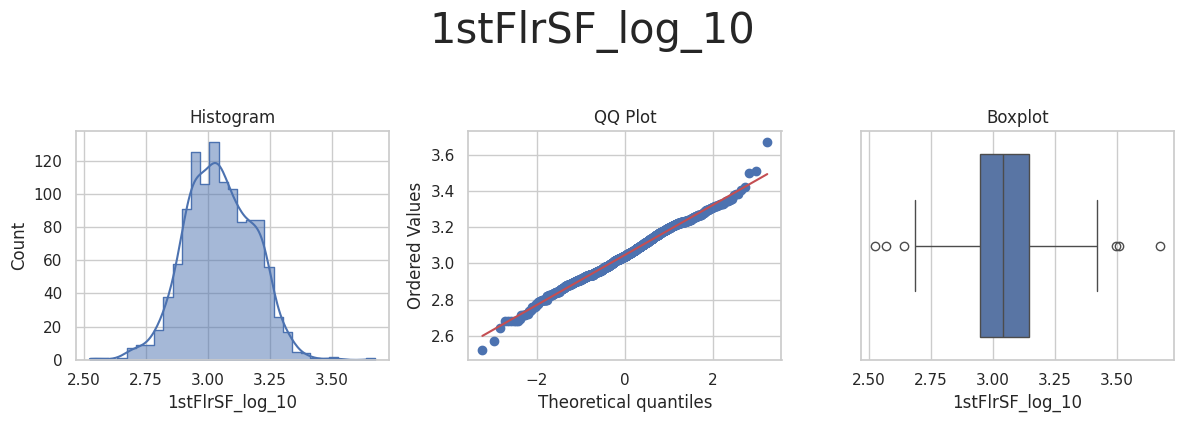

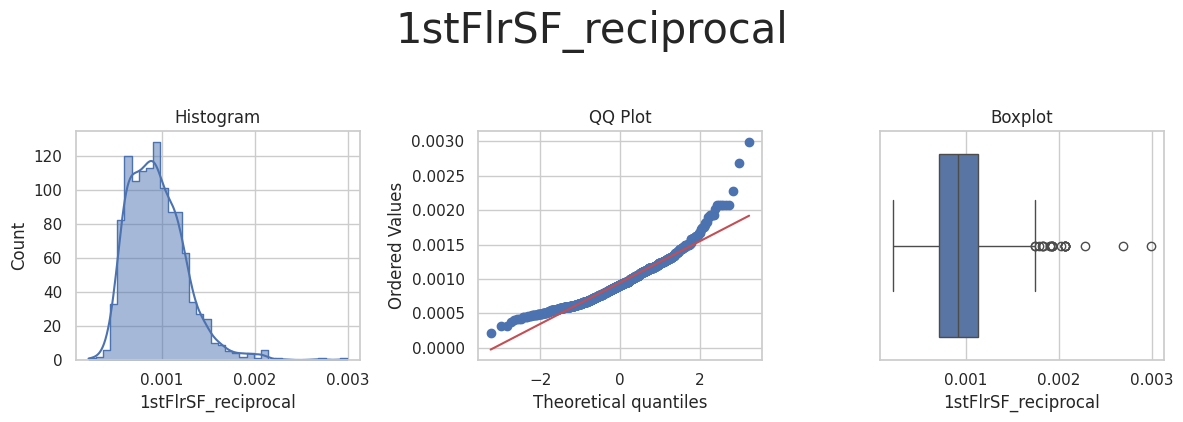

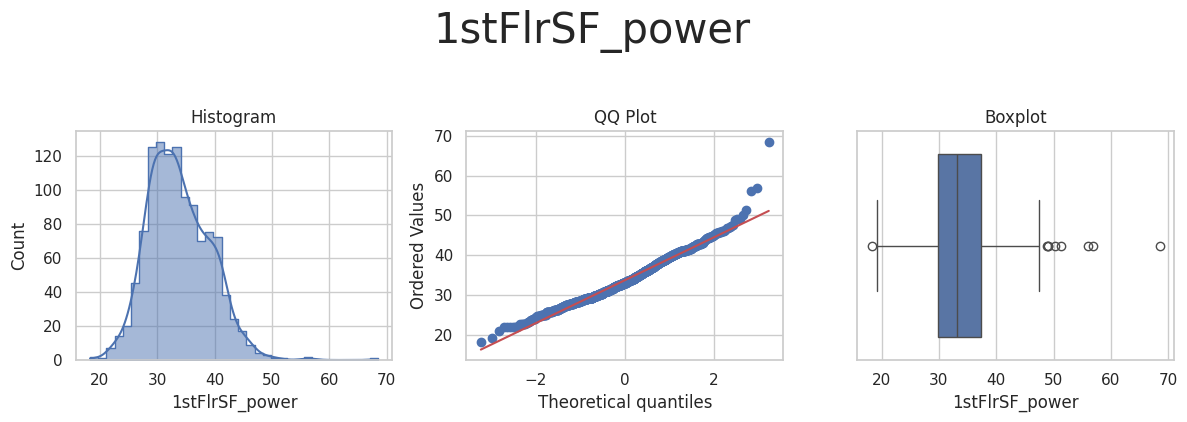

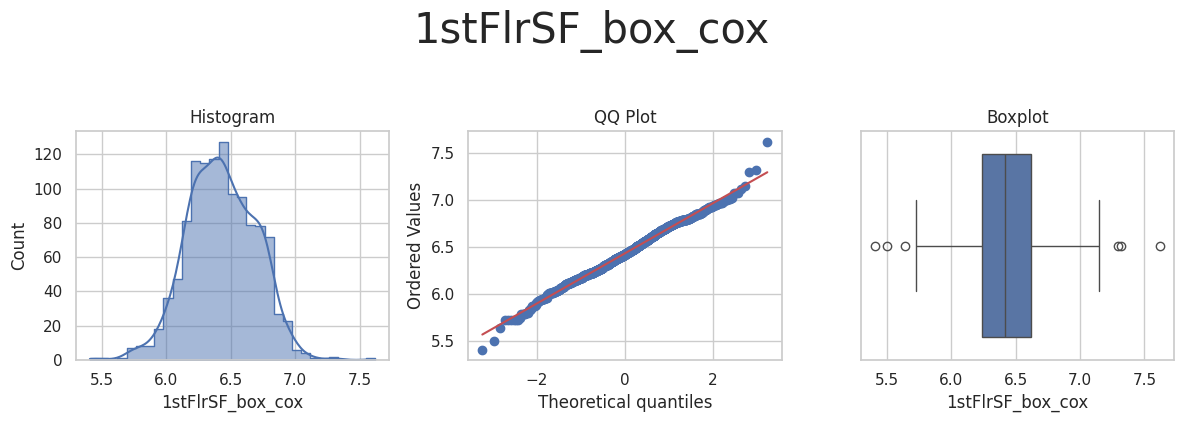

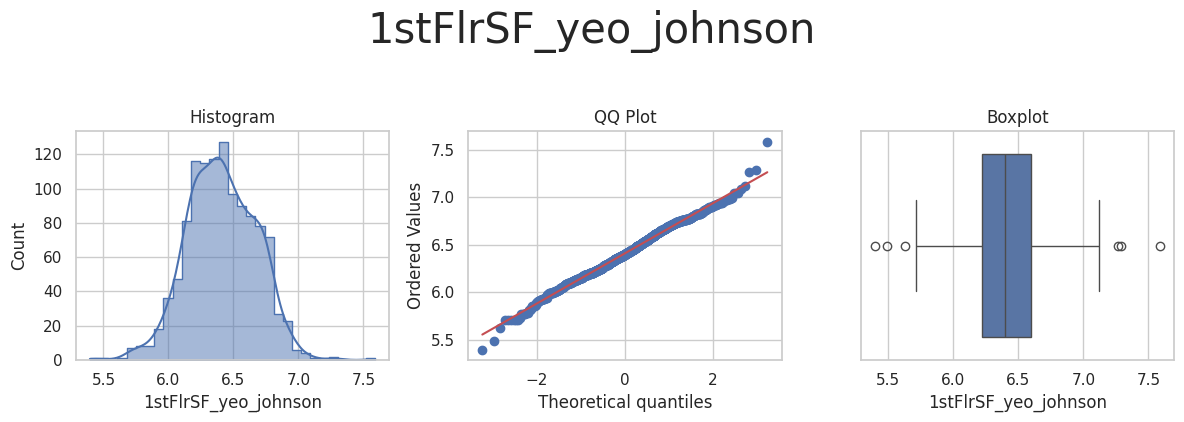



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



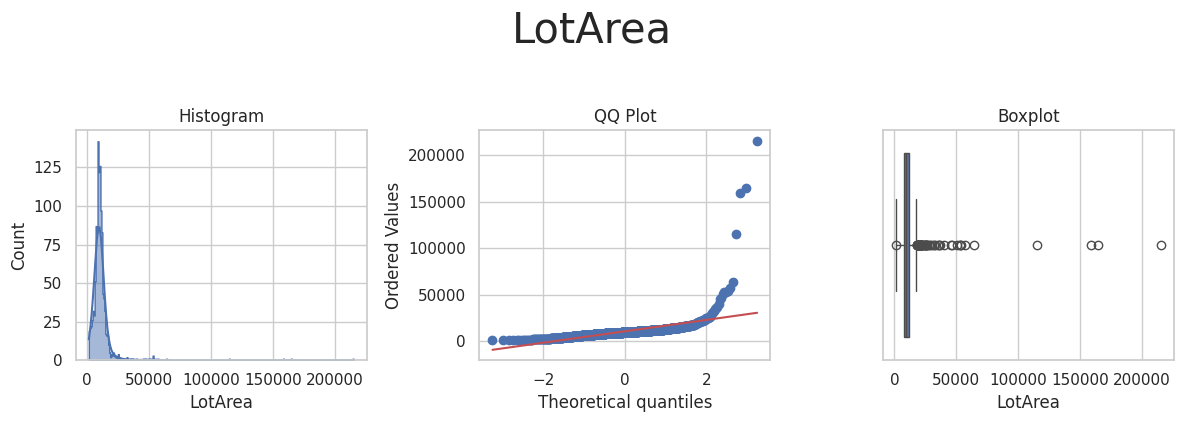

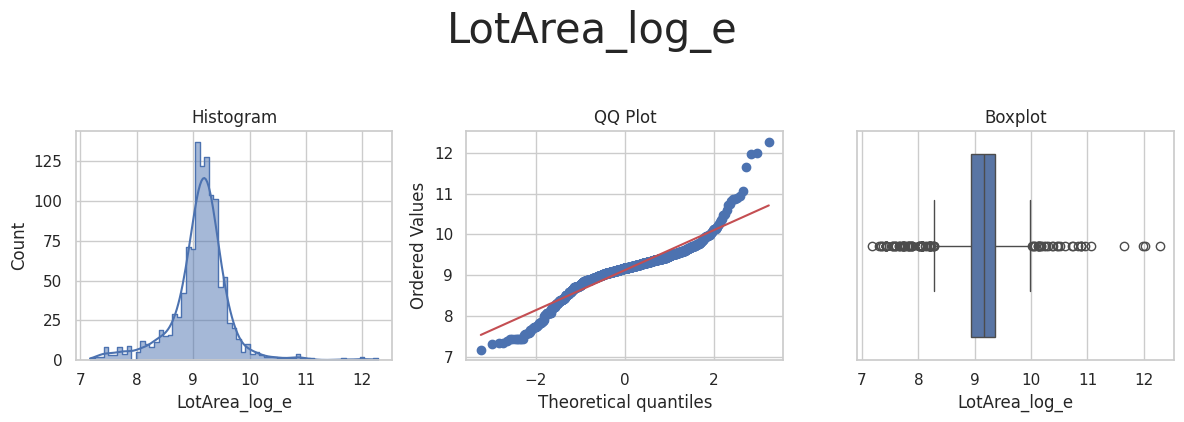

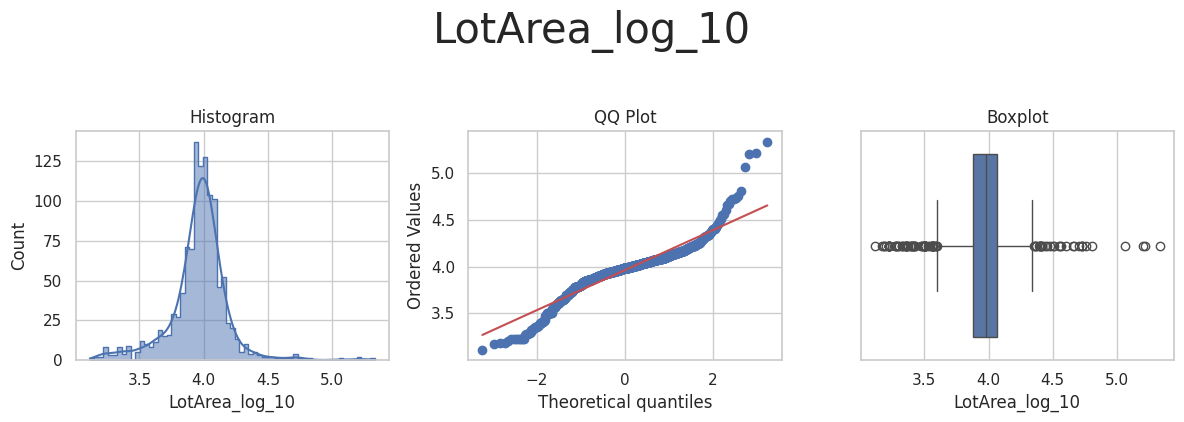

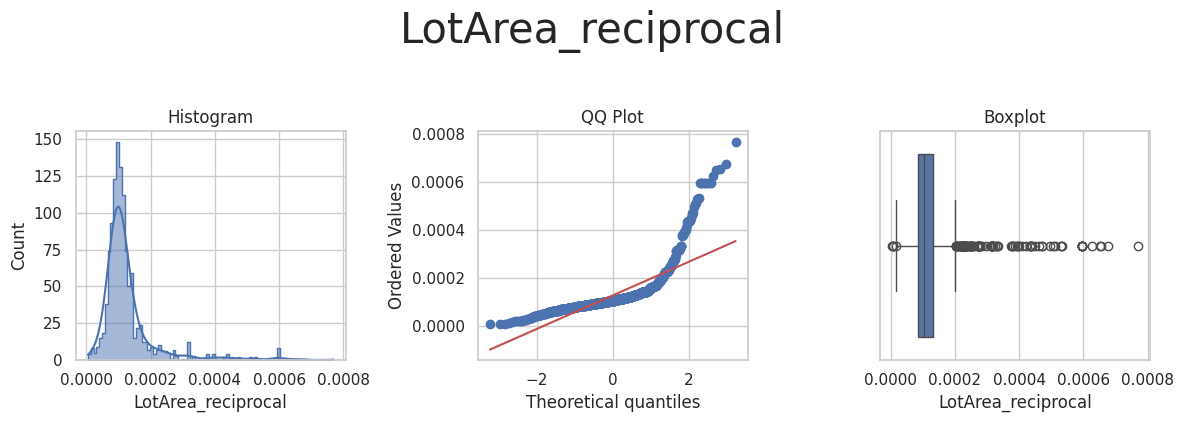

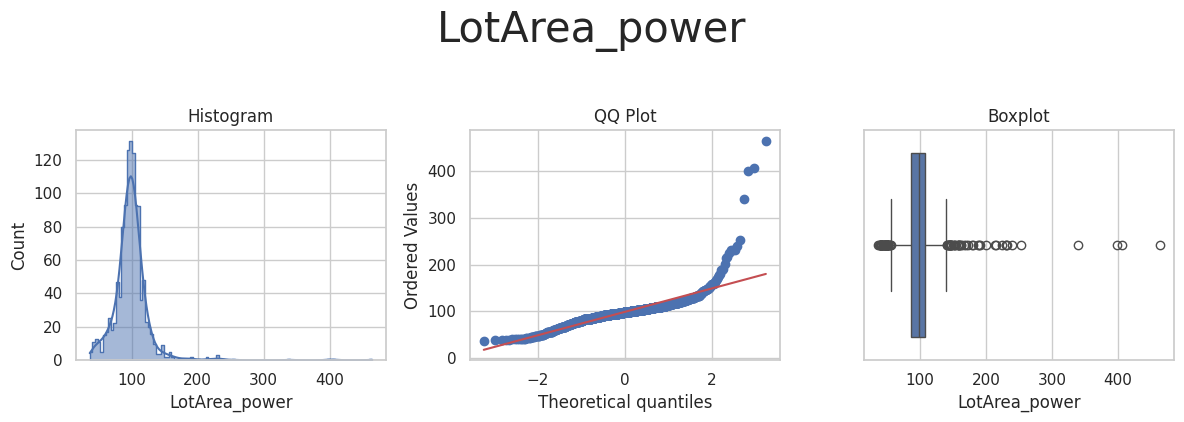

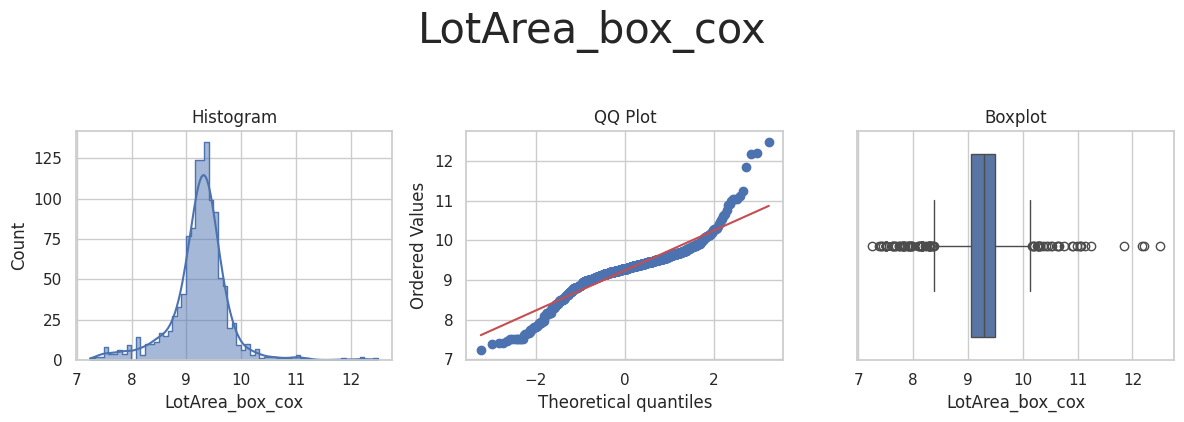

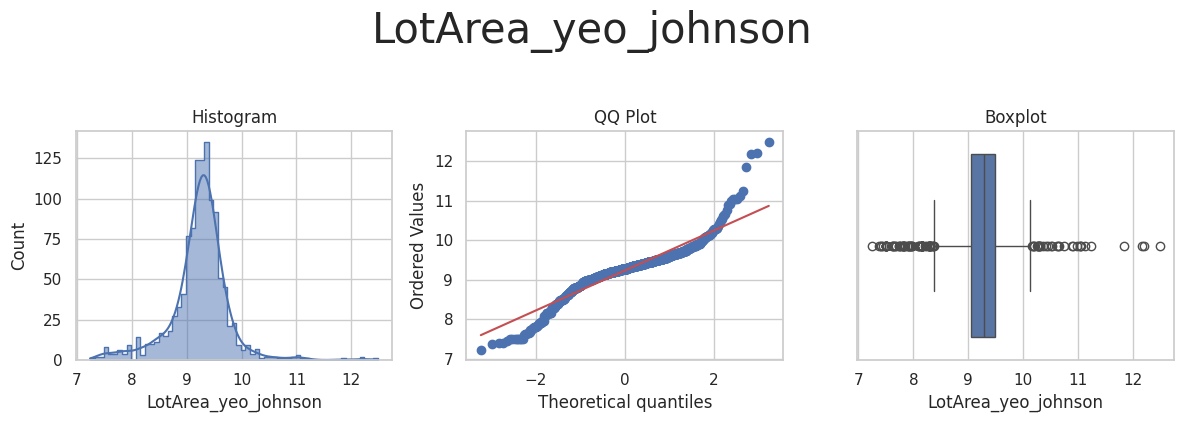

,GrLivArea,GrLivArea_log_e,GrLivArea_log_10,GrLivArea_reciprocal,GrLivArea_power,GrLivArea_box_cox,GrLivArea_yeo_johnson,GarageArea,GarageArea_power,GarageArea_yeo_johnson,...,1stFlrSF_power,1stFlrSF_box_cox,1stFlrSF_yeo_johnson,LotArea,LotArea_log_e,LotArea_log_10,LotArea_reciprocal,LotArea_power,LotArea_box_cox,LotArea_yeo_johnson
0,1314,7.180831,3.118595,0.000761,36.249138,7.020511,7.001803,294,17.146428,133.051252,...,36.249138,6.571998,6.549951,8400,9.035987,3.924279,0.000119,91.651514,9.152190,9.146925
1,1571,7.359468,3.196176,0.000637,39.635842,7.191135,7.171345,380,19.493589,164.747486,...,28.266588,6.153830,6.135072,7837,8.966611,3.894150,0.000128,88.526832,9.081029,9.075856
2,796,6.679599,2.900913,0.001256,28.213472,6.540734,6.525080,0,0.000000,0.000000,...,28.213472,6.150648,6.131915,8777,9.079890,3.943346,0.000114,93.685645,9.197229,9.191907
3,1768,7.477604,3.247482,0.000566,42.047592,7.303866,7.283360,240,15.491933,112.345106,...,31.320920,6.326960,6.306840,7200,8.881836,3.857332,0.000139,84.852814,8.994092,8.989031
4,1691,7.433075,3.228144,0.000591,41.121770,7.261385,7.241149,308,17.549929,138.308964,...,32.031235,6.364681,6.344264,5000,8.517193,3.698970,0.000200,70.710678,8.620385,8.615808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,1314,7.180831,3.118595,0.000761,36.249138,7.020511,7.001803,440,20.976177,186.123966,...,36.249138,6.571998,6.549951,9317,9.139596,3.969276,0.000107,96.524608,9.258490,9.253088
1164,1981,7.591357,3.296884,0.000505,44.508426,7.412336,7.391137,576,24.000000,232.852098,...,36.441734,6.580850,6.558734,7804,8.962392,3.892317,0.000128,88.340251,9.076701,9.071534
1165,864,6.761573,2.936514,0.001157,29.393877,6.619302,6.603144,572,23.916521,231.506990,...,29.393877,6.219920,6.200641,8172,9.008469,3.912328,0.000122,90.399115,9.123962,9.118734
1166,1426,7.262629,3.154120,0.000701,37.762415,7.098663,7.079460,216,14.696938,102.893134,...,30.199338,6.265531,6.245894,7642,8.941415,3.883207,0.000131,87.418534,9.055188,9.050048


In [9]:
FeatureEngineeringAnalysis(X_train[selected_num_cols], analysis_type='numerical')

* For each variable, write your conclusion on how the transformation(s) look(s) to be effective
  * For all variables - it didn't improve the boxplot distribution or qq plot


* Step 4 - Apply the selected transformation to the Train and Test set

In [10]:
from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer, BoxCoxTransformer

# Apply selected transformations
log_tr = LogTransformer(variables=['GrLivArea'])
yj_tr = YeoJohnsonTransformer(variables=['GarageArea'])
bc_tr = BoxCoxTransformer(variables=['LotArea'])

X_train = log_tr.fit_transform(X_train)
X_train = yj_tr.fit_transform(X_train)
X_train = bc_tr.fit_transform(X_train)

# Save transformers to apply the same to test set later

---

# So what is the conclusion? :)


The list below shows the transformations needed for feature engineering.
  * You will add these steps to the ML Pipeline

Numerical Transformations
| Transformation Type     | Tool (Scikit-learn or Feature-engine)                 | Applies to         | Why                                             |
| ----------------------- | ----------------------------------------------------- | ------------------ | ----------------------------------------------- |
| `LogTransformer`        | `feature_engine.transformation.LogTransformer`        | e.g., `GrLivArea`  | Reduces skew, makes linear models more accurate |
| `BoxCoxTransformer`     | `feature_engine.transformation.BoxCoxTransformer`     | e.g., `LotArea`    | Normalizes spread, improves fit                 |
| `YeoJohnsonTransformer` | `feature_engine.transformation.YeoJohnsonTransformer` | e.g., `GarageArea` | Safe for 0s and negatives                       |
| (optional) `Winsorizer` | `feature_engine.outliers.Winsorizer`                  | All numerical      | Caps extreme values (outliers)                  |

Categorical Encoding
| Encoding Type              | Tool                                     | Applies to                             | Why                                               |
| -------------------------- | ---------------------------------------- | -------------------------------------- | ------------------------------------------------- |
| `OrdinalEncoder`           | `feature_engine.encoding.OrdinalEncoder` | e.g., `KitchenQual`, `GarageFinish`    | Converts string categories to meaningful integers |
| (optional) `OneHotEncoder` | `sklearn.preprocessing.OneHotEncoder`    | For nominal variables (if added later) | Needed for tree models                            |
